# 특이값 분해 (Singuler Value Decomposition : SVD)

- 3가지 데이터로 분해
  - 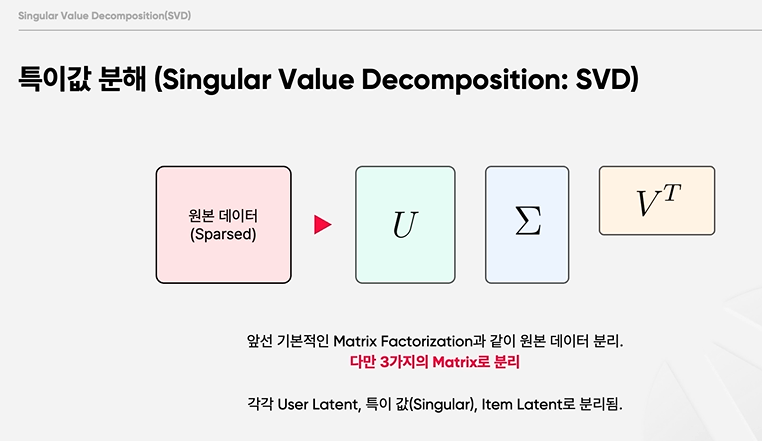
- 특이 값은 n*n 데이터만 데이터 존재 (대각행렬)

### 차원축소
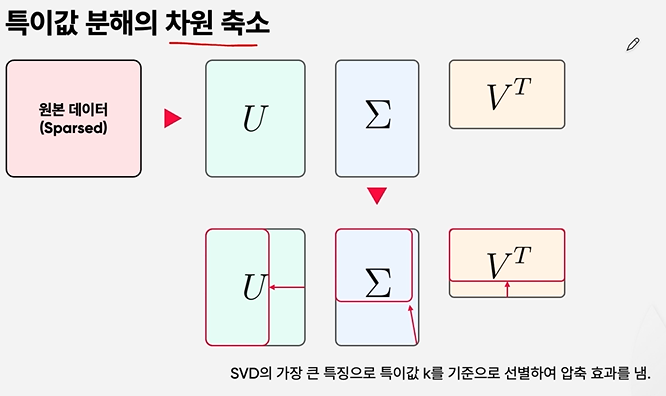


In [1]:
%conda install -y scikit-learn pandas datasets tqdm

Retrieving notices: done
Channels:
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - datasets
    - pandas
    - scikit-learn
    - tqdm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    aiohappyeyeballs-2.4.4     |  py311h06a4308_0          27 KB
    aiohttp-3.11.10            |  py311h5eee18b_0         950 KB
    aiosignal-1.2.0            |     pyhd3eb1b0_0          12 KB
    arrow-cpp-19.0.0           |       h865e1df_0        12.5 MB
    attrs-24.3.0               |  py311h06a4308_0         174 KB
    aws-c-auth-0.6.19          |       h5eee18b_0          99 KB
    aws-c-cal-0.5.20           |       hdbd6064_0          42 KB
    aws-c-common-0.8.5         |       h5eee18b_0         207 KB
    aws-c-compression-0.2.16   |       h5eee18b_0          18 KB
    aws-c-event-stream-0.2.15  |     

In [3]:
%pip install -U matplotlib

  Using cached matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [5]:
# Data Load
data = load_dataset("nbtpj/movielens-1m-ratings")["train"].shuffle(seed=10).select(range(200000))
movielens_df = pd.DataFrame(data)
moveslens_df = movielens_df[["user_id", "movie_id", "user_rating"]]

# map 함수를 사용하여 원래의 사용자 id를 정수 인덱스로 변환
user_ids = movielens_df["user_id"].unique()
user_id_map = {id: index for index, id in enumerate(user_ids)}
movie_ids = movielens_df["movie_id"].unique()
movie_id_map = {id: index for index, id in enumerate(movie_ids)}

movielens_df["user_id"] = movielens_df["user_id"].map(user_id_map)
movielens_df["movie_id"] = movielens_df["movie_id"].map(movie_id_map)

Generating train split: 100%|██████████| 1000209/1000209 [00:01<00:00, 575361.04 examples/s]


In [9]:
train_data, test_data = train_test_split(movielens_df, test_size=0.2, random_state=10)

user_avg_ratings = train_data.groupby('user_id')['user_rating'].mean().to_dict()
ratings_matrix = train_data.pivot(index="user_id", columns="movie_id", values="user_rating").apply(lambda x: x.fillna(user_avg_ratings[x.name]), axis=1)
user_rating_mean = ratings_matrix.mean(axis=1)
ratings_matrix_demeaned = ratings_matrix - user_rating_mean.values.reshape(-1, 1)
ratings_matrix_csr = csr_matrix(ratings_matrix_demeaned.values)

U, sigma, Vt = svds(ratings_matrix_csr, k=50)
sigma = np.diag(sigma)

In [11]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_rating_mean.values.reshape(-1, 1)
user_mean = np.mean(all_user_predicted_ratings)

def predict_rating_svd(user_id: int, movie_id: int):
    if user_id < all_user_predicted_ratings.shape[0] and movie_id < all_user_predicted_ratings.shape[1]:
        return all_user_predicted_ratings[user_id, movie_id]
    else:
        return user_mean

predictions: list[float] = []
true_ratings: list[float] =[]

for _, row in tqdm(test_data.iterrows(), total=test_data.shape[0]):
    user_id = int(row["user_id"])
    movie_id = int(row["movie_id"])
    true_rating = row["user_rating"]

    predicted_rating = predict_rating_svd(user_id, movie_id)
    predictions.append(round(predicted_rating))
    true_ratings.append(true_rating)

rmse = np.sqrt(np.mean((np.array(predictions) - np.array(true_ratings))**2))
print(f"RMSE: {rmse}")

100%|██████████| 40000/40000 [00:02<00:00, 14847.49it/s]

RMSE: 1.2060058042978068


Text(0.5, 1.0, 'Predicted vs. Actual Rating Distribution')

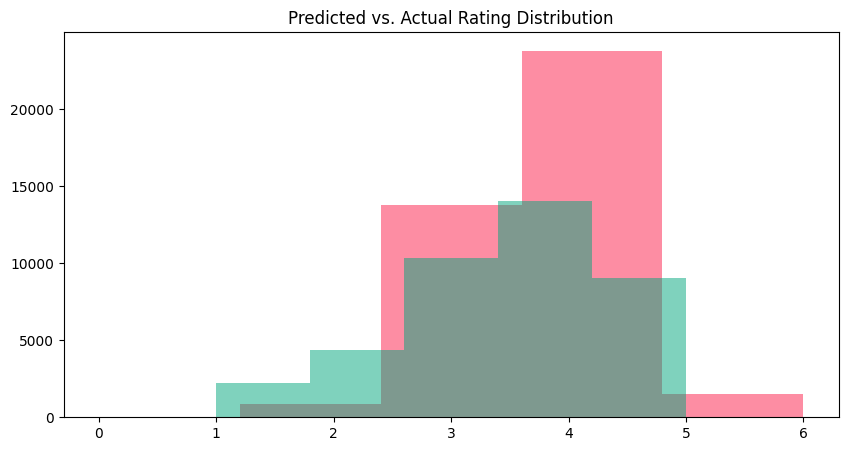

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(predictions, bins=5, alpha=0.5, label="Predicted", color="#fc1c49")
plt.hist(true_ratings, bins=5, alpha=0.5, label="Actual", color="#00a67d")
plt.title("Predicted vs. Actual Rating Distribution")